# Analyze A/B Test Results

 May 3 -2020

#### NIMMY GEORGE
Project 2

Udacity -Data Analyst NanoDegree

#### Table of Contents

Introduction

Part I - Probability

Part II - A/B Test

Part III - Regression

#### Introduction
A/B tests are very commonly performed by data analysts and data scientists. It is important that you get some practice working with the difficulties of these.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question. The labels for each classroom concept are provided for each question. This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria. As a final check, assure you meet all the criteria on the RUBRIC.

#### Part I - Probability
To get started, let's import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

#### 1. Now, read in the ab_data.csv data. Store it in df. Use your dataframe to answer the questions in Quiz 1 of the classroom.

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df=pd.read_csv('Desktop/ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
df.converted.mean()

0.11965919355605512

e. The number of times the new_page and treatment don't line up.

In [8]:
df.query('group=="treatment" and landing_page != "new_page" or group=="control" and landing_page=="new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

2. For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. Use Quiz 2 in the classroom to provide how we should handle these rows.

  a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz. Store your new  dataframe in df2.

In [10]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]


3893

In [11]:
indexes=df.query('group=="treatment" and landing_page!="new_page" or group=="control" and landing_page!="old_page"').index.values
indexes

array([    22,    240,    308, ..., 294252, 294253, 294331], dtype=int64)

In [12]:
df2=df.drop(indexes)

In [13]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3. Use df2 and the cells below to answer questions for Quiz3 in the classroom.

    a. How many unique user_ids are in df2?

In [14]:
df2.user_id.nunique()

290584

In [15]:
df2.shape

(290585, 5)

b. There is one user_id repeated in df2. What is it?

c. What is the row information for the repeat user_id?

In [16]:
df2[df2.duplicated(subset="user_id", keep=False)]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.

In [17]:
df2.drop(1899, inplace=True)
df2[df2.duplicated(subset="user_id", keep=False)]

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []

4. Use df2 in the below cells to answer the quiz questions related to Quiz 4 in the classroom.

    a. What is the probability of an individual converting regardless of the page they receive?



In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the control group, what is the probability they converted?

In [19]:
ctr_convert=df2.query('group=="control"').converted.mean()

c. Given that an individual was in the treatment group, what is the probability they converted?

In [20]:
exp_convert=df2.query('group=="treatment"').converted.mean()

In [21]:
d=exp_convert - ctr_convert
d

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page=="new_page"').count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

 No, there's not sufficient evidence that the treatment page results in more conversions. If we were to conclude from the above numbers, it suggests that control pages have more conversions.


### Part II - A/B Test
Notice that due to the time stamp related to each event, you'll technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is does one stop as soon together page is taken into account significantly better than another or does it got to happen consistently for a particular amount of time? How long does one run to render a choice that neither page is best than another?

These questions are the difficult parts related to A/B tests generally .

1. For now, consider you would like to form the choice just supported all the info provided. If you would like to assume that the old page is best unless the new page proves to be definitely better at a kind I error rate of fifty , what should your null and alternative hypotheses be? you'll state your hypothesis in terms of words or in terms of pold and pnew , which are the converted rates for the old and new pages.

                H0 : pnew <= pold
                H1: pnew > pold
2. Assume under the null hypothesis, pnew and pold both have "true" success rates adequate to the converted success rate no matter page - that's pnew and pold are equal. Furthermore, assume they're adequate to the converted rate in ab_data.csv no matter the page.


Use a sample size for every page adequate to those in ab_data.csv.


Perform the sampling distribution for the difference in converted between the 2 pages over 10,000 iterations of calculating an estimate from the null.


Use the cells below to supply the required parts of this simulation. If this does not make complete sense immediately , don't be concerned - you're getting to run through the issues below to finish this problem. you'll use Quiz 5 within the classroom to form sure you're on the proper track.


a. What is the convert rate for  pnew  under the null?



In [24]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the convert rate for  pold  under the null?

In [25]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is nnew ?

In [26]:
n_new=df2.query('landing_page=="new_page"').count()[0]
n_new

145310

In [27]:
n_old=df2.query('landing_page=="old_page"').count()[0]
n_old

145274

e. Simulate  nnew  transactions with a convert rate of  pnew  under the null. Store these  nnew  1's and 0's in new_page_converted.

In [28]:
p=[p_new for i in range(n_new)]
len(p)

145310

In [29]:
df2.converted.count()

290584

In [30]:
new_page_converted= np.random.binomial(1, p=p_new, size=n_new) 
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate  nold  transactions with a convert rate of  pold  under the null. Store these  nold  1's and 0's in old_page_converted.

In [31]:
old_page_converted= np.random.binomial(1, p=p_old, size=n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find  pnew  -  pold  for your simulated values from part (e) and (f).

In [32]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

0.0023035427508649453

h. Simulate 10,000  pnew  -  pold  values using this same process similarly to the one you calculated in parts a. through g. above. Store all 10,000 values in a numpy array called p_diffs.

In [33]:
p_diffs=[]
new_convert=np.random.binomial(n_new, p_new, 10000)/n_new
old_convert=np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs=new_convert-old_convert

i. Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.

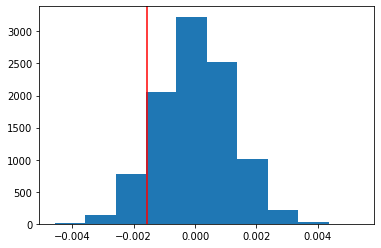

In [34]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(d, color='red')

j. What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [35]:
(d < p_diffs).mean()

0.902

k. In words, explain what you just computed in part j. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?


This is the P-value, which suggests if there is a significant difference between 2 groups for a hypothesis. In this case, the new page doesn't have better conversion rates than the old page because the value 0.9 is much higher than the alpha, 0.05.


l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" and converted==1').count()[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').count()[0]
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]
print(convert_old)
print(n_old)
print(convert_new)
print(n_new)

17489
145274
17264
145310


m. Now use stats.proportions_ztest to compute your test statistic and p-value. Here is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
print(p_value)
print(z_score)

0.9050583127590245
-1.3109241984234394


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts j. and k.?

The z-score is the number of standard deviation a data-point is from the population mean. It is greater than the value of -0.1645 (one-tail test) and hence it suggests that we can't reject the null. And the p-value determines the significance of our resuls. The values are different from parts j and k but it still suggests that there is no statistically significant difference betweem the new and the old page.

### Part III - A regression approach
1. In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.


    a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Logistic Regression.

 b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [38]:
df2['intercept']=1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()


user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns you created in part b. to predict whether or not an individual converts.

In [39]:
import statsmodels.api as sm

mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit() #Fitting the model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        10:02:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?


The p-value here suggests that that new page is not statistically significant as 0.19 > 0.05. The values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or been mutually exclusive to an extent to give different values such that differet p-values were received than what we got in logistic regression.

f. Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

Considering other factors/explanatory variables makes our hypothesis results more reliable as it can improve the r-sqaured values plus we might miss other influencing factors of out response variables. But if multicolinearity exists, that is correlation between explanatory variables then our results will be wrong. So we need to make sure that there is no multicolinearity.



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows. Here are the docs for joining tables.

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns.Provide the statistical output as well as a written response to answer this question.

In [42]:
countries_df = pd.read_csv('Desktop/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') #Merging 2 data frames with index as user_id
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  
user_id                                 
834778           0          1        0  
928468           0          1        1  
822059           1          1        1  
711597           0          1        0  
710616           0          1        1

In [43]:
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  CA  UK  US  
user_id                                             
834778           0          1        0   0   1   0  
928468           0          1        1   0   0   1  
822059           1          1        1   0   1   0  
711597           0          1        0   0   1   0  
710616           0          1        1   0   1   0

In [44]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        10:04:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [45]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        10:05:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

### Conclusions

From the above results there's no significant impact of the countries and new page on conversion rates. the corporate shouldn't implement this new page as there's no conclusive evidence that it's better than the old page.